# Fine Tuning Transformer for MultiLabel Text Classification

# This notebook was copied from https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb and modified as per our requirements

### Introduction

In this tutorial we will be fine tuning a transformer model for the **Multilabel text classification** problem.
This is one of the most common business problems where a given piece of text/sentence/document needs to be classified into one or more of categories out of the given list. For example a movie can be categorized into 1 or more genres.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data:
	 - We are using the Jigsaw toxic data from [Kaggle](https://www.kaggle.com/)
     - This is competion provide the souce dataset [Toxic Comment Competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
	 - We are referring only to the first csv file from the data dump: `train.csv`
	 - There are rows of data.  Where each row has the following data-point:
		 - Comment Text
		 - `toxic`
		 - `severe_toxic`
		 - `obscene`
		 - `threat`
		 - `insult`
		 - `identity_hate`

Each comment can be marked for multiple categories. If the comment is `toxic` and `obscene`, then for both those headers the value will be `1` and for the others it will be `0`.


 - Language Model Used:
	 - BERT is used for this project. It was the transformer model created by the Google AI Team.  
	 - [Blog-Post](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)
	 - [Research Paper](https://arxiv.org/abs/1810.04805)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/bert.html)

---
***NOTE***
- *It is to be noted that the outputs to the BERT model are different from DistilBert Model implemented by the Hugging Face team. There are no `token_type_ids` generated from the tokenizer in case of Distilbert and also the final outputs from the network differ.*
- *This will be explained further in the notebook*
---

 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup


 - Script Objective:
	 - The objective of this script is to fine tune BERT to be able to label a comment  into the following categories:
		 - `toxic`
		 - `severe_toxic`
		 - `obscene`
		 - `threat`
		 - `insult`
		 - `identity_hate`

---
***NOTE***
- *It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:*
	- *Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of `BCE` rather than `Cross Entropy` when defining loss.*
	- *Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point*
	- *The [accuracy metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and [F1 scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) used from sklearn package as compared to direct comparison of expected vs predicted*
---

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* BERT Model and Tokenizer

Followed by that we will preapre the device for GPU execeution. This configuration is needed if you want to leverage on onboard GPU.

*I have included the code for TPU configuration, but commented it out. If you plan to use the TPU, please comment the GPU execution codes and uncomment the TPU ones to install the packages and define the device.*

In [ ]:
# Installing the transformers library and additional libraries if looking process

!pip install -q transformers
# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

In [ ]:

# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig


# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes.
*Assuming that the `train.csv` is already downloaded, unzipped and saved in your `data` folder*

* Import the file in a dataframe and give it the headers as per the documentation.
* Taking the values of all the categories and coverting it into a list.
* The list is appened as a new column and other columns are removed

In [ ]:
df = pd.read_csv("/content/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<a id='section03'></a>
### Preparing the Dataset and Dataloader

We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of CustomDataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing.
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *CustomDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT model for training.
- We are using the BERT tokenizer to tokenize the data in the `comment_text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`
---
- *This is the first difference between the distilbert and bert, where the tokenizer generates the token_type_ids in case of Bert*
---
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer)
- `targest` is the list of categories labled as `0` or `1` in the dataframe.
- The *CustomDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training.

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

<ipython-input-5-550ab2af7edf>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.values,


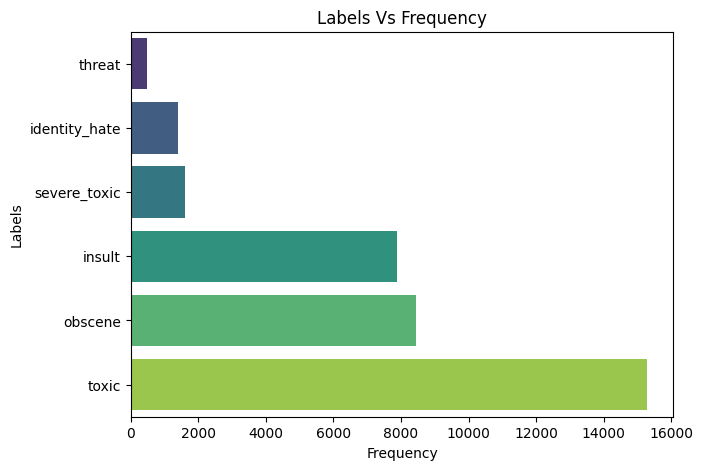

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the class distribution of the 'label' column
column_labels = df.columns.tolist()[2:]
label_counts = df[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
                 y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.title('Labels Vs Frequency')

# Show the plot
plt.show()

<ipython-input-6-be57b46a66e0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


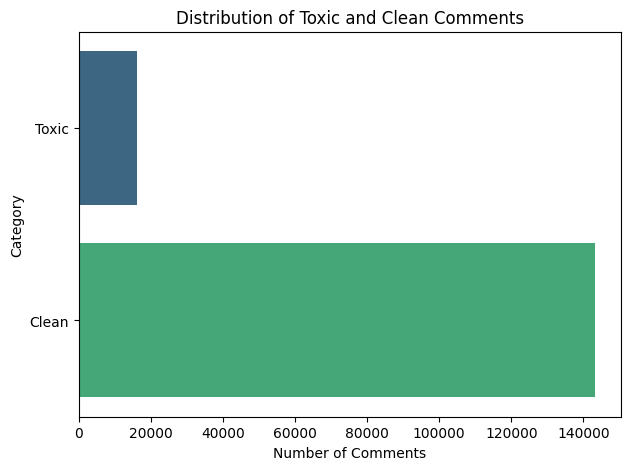

In [ ]:
# Create subsets based on toxic and clean comments
train_toxic = df[df[column_labels].sum(axis=1) > 0]
train_clean = df[df[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()

In [ ]:
print(train_toxic.shape)
print(train_clean.shape)

(16225, 8)
(143346, 8)


In [ ]:
train_clean_sampled = train_clean.sample(16225)

In [ ]:
print(train_toxic.shape)
print(train_clean_sampled.shape)

(16225, 8)
(16225, 8)


In [ ]:
# 143346/16225

In [ ]:
# Randomly sample 15,000 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
df = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
df = df.sample(frac=1, random_state=42)

In [ ]:
(df[df.columns.tolist()[2:]].sum(axis=1) > 0)*1

57737     1
46617     0
83356     1
34637     1
27887     1
         ..
19524     0
52404     1
8141      1
155400    1
57748     0
Length: 32450, dtype: int64

In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = (dataframe[dataframe.columns.tolist()[2:]].sum(axis=1) > 0)*1 #self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (32450, 8)
TRAIN Dataset: (25960, 8)
TEST Dataset: (6490, 8)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `BERTClass`.
 - This network will have the `Bert` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively.
 - In the forward loop, there are 2 output from the `BertModel` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`.
 - Keep note the number of dimensions for `Linear Layer` is **6** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `BertClass` as defined in the dataset.
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction.
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.

#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

#### Further Reading
- You can refer to my [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials) to get an intuition of Loss Function and Optimizer.
- [Pytorch Documentation for Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Pytorch Documentation for Optimizer](https://pytorch.org/docs/stable/optim.html)
- Refer to the links provided on the top of the notebook to read more about `BertModel`.

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.2)
        self.l3 = torch.nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
# pos_weight = torch.tensor([143346/16225]).to(device)
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process.

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size.
- Subsequent output from the model and the actual category are compared to calculate the loss.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a miniscule loss of 0.022 i.e. the network output is extremely close to the actual output.

In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        # print(outputs.shape, targets.shape)
        loss = loss_fn(outputs, targets.reshape(-1,1))
        if _%100==0:
          print(f'Epoch: {epoch}, Batch:{_}/{len(training_loader)}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
for epoch in range(3):
    train(epoch)

Epoch: 0, Batch:0/3245, Loss:  0.7572806477546692
Epoch: 0, Batch:100/3245, Loss:  0.30215680599212646
Epoch: 0, Batch:200/3245, Loss:  0.42102640867233276
Epoch: 0, Batch:300/3245, Loss:  0.2095244824886322
Epoch: 0, Batch:400/3245, Loss:  0.09786000847816467
Epoch: 0, Batch:500/3245, Loss:  0.29530495405197144
Epoch: 0, Batch:600/3245, Loss:  0.1976628303527832
Epoch: 0, Batch:700/3245, Loss:  0.039103202521800995
Epoch: 0, Batch:800/3245, Loss:  0.36665603518486023
Epoch: 0, Batch:900/3245, Loss:  0.29818493127822876
Epoch: 0, Batch:1000/3245, Loss:  0.1055687963962555
Epoch: 0, Batch:1100/3245, Loss:  0.11354922503232956
Epoch: 0, Batch:1200/3245, Loss:  0.029585499316453934
Epoch: 0, Batch:1300/3245, Loss:  0.3279591500759125
Epoch: 0, Batch:1400/3245, Loss:  0.6970822811126709
Epoch: 0, Batch:1500/3245, Loss:  0.08917419612407684
Epoch: 0, Batch:1600/3245, Loss:  0.1990385502576828
Epoch: 0, Batch:1700/3245, Loss:  0.1879345178604126
Epoch: 0, Batch:1800/3245, Loss:  0.0321980789

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage.
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

As defined above to get a measure of our models performance we are using the following metrics.
- Accuracy Score
- F1 Micro
- F1 Macro

We are getting amazing results for all these 3 categories just by training the model for 1 Epoch.

In [ ]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            print(f"{_}/{len(testing_loader)}")
    return fin_outputs, fin_targets

In [ ]:
# for epoch in range(EPOCHS):
outputs, targets = validation(epoch)
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

0/1623
1/1623
2/1623
3/1623
4/1623
5/1623
6/1623
7/1623
8/1623
9/1623
10/1623
11/1623
12/1623
13/1623
14/1623
15/1623
16/1623
17/1623
18/1623
19/1623
20/1623
21/1623
22/1623
23/1623
24/1623
25/1623
26/1623
27/1623
28/1623
29/1623
30/1623
31/1623
32/1623
33/1623
34/1623
35/1623
36/1623
37/1623
38/1623
39/1623
40/1623
41/1623
42/1623
43/1623
44/1623
45/1623
46/1623
47/1623
48/1623
49/1623
50/1623
51/1623
52/1623
53/1623
54/1623
55/1623
56/1623
57/1623
58/1623
59/1623
60/1623
61/1623
62/1623
63/1623
64/1623
65/1623
66/1623
67/1623
68/1623
69/1623
70/1623
71/1623
72/1623
73/1623
74/1623
75/1623
76/1623
77/1623
78/1623
79/1623
80/1623
81/1623
82/1623
83/1623
84/1623
85/1623
86/1623
87/1623
88/1623
89/1623
90/1623
91/1623
92/1623
93/1623
94/1623
95/1623
96/1623
97/1623
98/1623
99/1623
100/1623
101/1623
102/1623
103/1623
104/1623
105/1623
106/1623
107/1623
108/1623
109/1623
110/1623
111/1623
112/1623
113/1623
114/1623
115/1623
116/1623
117/1623
118/1623
119/1623
120/1623
121/1623
122/1623
123

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(targets, outputs)

array([[2964,  274],
       [ 114, 3138]])

In [ ]:
np.sum(outputs==False)

27089

In [ ]:
torch.save(model, "./toxicclassifier-bal.pt")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/My Drive/685"

In [ ]:
!cp "/content/toxicclassifier-bal.pt" "/content/drive/My Drive/685/"

In [ ]:
load_model = torch.load("./toxicclassifier.pt")

In [ ]:
for _, data in enumerate(testing_loader, 0):
  ids = data['ids'].to(device, dtype = torch.long)
  mask = data['mask'].to(device, dtype = torch.long)
  token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
  targets = data['targets'].to(device, dtype = torch.float)
  print(load_model(ids, mask, token_type_ids))
  print(model(ids, mask, token_type_ids))
  break

tensor([[-7.4673],
        [-6.8375],
        [-5.9552],
        [-6.9532]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-7.4673],
        [-6.8375],
        [-5.9552],
        [-6.9532]], device='cuda:0', grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
targets

tensor([0., 0., 0., 0.], device='cuda:0')

<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model.

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

Please remember that a trained neural network is only useful when used in actual inference after its training.

In the lifecycle of an ML projects this is only half the job done. We will leave the inference of these models for some other day.